In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import numpy
import os
import random
from PIL import Image

label=['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
batch_count = 0
x_train_size = 0
x_train = 0

def get_array(file_name,format_size):
    path = "./flower_dataset/"+file_name+"/"
    images = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.jpg' in file:
                image = Image.open(os.path.join(r, file))
                image = image.resize((format_size,format_size))
                image = list(numpy.asarray(image))
                images.append(image)
    return images

def one_hot_(a):
    global label
    b = numpy.zeros((a.size, len(label)))
    for i in range(len(a)):
        b[i][label.index(a[i])] = 1
    return b

def get_data(test_cut=0.8, normalize=True, one_hot=False, format_size=28):
    global x_train_size
    global x_train
    all_img = []
    all_label = []
    for i in label:
        print(i)
        img_tmp = get_array(i, format_size)
        label_tmp = list(numpy.full(len(img_tmp), i))
        if i == 'daisy':
            all_img = img_tmp
        else:
            all_img += img_tmp
        all_label += label_tmp
    img_random = []
    label_random = []
    r=random.sample(range(0, len(all_label)), len(all_label))
    for i in range(len(r)):
        img_random += [all_img[int(r[i])]]
        label_random += [all_label[int(r[i])]]
    img_random = numpy.asarray(img_random)
    label_random = numpy.asarray(label_random)
    if(normalize == True):
        img_random = img_random.astype('float32') / 255.0
    num = int(len(label_random) * test_cut)
    x_train = img_random[:num]
    y_train = label_random[:num]
    x_test = img_random[num:]
    y_test = label_random[num:]
    x_train_size = len(x_train)
    if(one_hot == True):
        y_train = one_hot_(y_train)
        y_test = one_hot_(y_test)
    return (x_train, y_train), (x_test, y_test)

def  next_batch(batch_size):
    global batch_count
    global x_train_size
    global x_train
    if(x_train_size == 0):
        get_data()
    if(batch_count+batch_size) >= x_train_size:
        batch_count = 0
    tmp=x_train[batch_count:batch_count + batch_size]
    batch_count += batch_size

    return tmp

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [ ]:
(x_train,y_train),(_,_)=get_data(format_size=28,normalize=False,one_hot=True)
x_train = (x_train - 127.5) / 127.5
y_train = y_train.astype(np.float64)
x_train=x_train[:3400]
y_train=y_train[:3400]

daisy
dandelion
rose
sunflower
tulip


In [ ]:
x_train

array([], dtype=float64)

In [ ]:
def discriminator_inp(inp_,tag):
    global label_batch_g
    a=list(inp_.shape)
    a[3]=5
    label=label_batch_g.numpy().tolist()
    y=np.zeros(a).astype(np.float64).tolist()
    for k in range(len(y)):
        for i in range(len(y[0])):
            for j in range(len(y[0][i])):
                y[k][i][j][label[k].index(1.)]=1.
    y=tf.convert_to_tensor(y)
    if tag ==1:
        y=tf.cast(y,tf.float64)
    else:
        y=tf.cast(y,tf.float32)
    dis_inp=tf.concat([inp_,y],3)
    return dis_inp

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 200
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    inp=tf.keras.Input()
    model.add(layers.Dense(7*7*256*3, use_bias=False, input_shape=(105,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7,256*3)))
    
    model.add(layers.Conv2DTranspose(128*3, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64*3, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1*3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return tf.keras.Model(inp)

In [ ]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
y = tf.convert_to_tensor([[0.,0.,0.,0.,1.]])
gen_inp = tf.concat([noise,y],1)
generated_image = generator(gen_inp, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, :]* 127.5 + 127.5)

ValueError: ignored

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64*3, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 8]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128*3, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 100000
noise_dim = 100
num_examples_to_generate = 10
global label_batch_g
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images,labels):
    print(type(images))
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    noise = tf.cast(noise,tf.float64)
    gen_inp=tf.concat([noise,labels],1)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_images = generator(gen_inp, training=True)
        real_dis_inp=discriminator_inp(images,tag=1)
        fake_dis_inp=discriminator_inp(generated_images,tag=0)
        real_output = discriminator(real_dis_inp, training=True)
        fake_output = discriminator(fake_dis_inp, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    global label_batch_g
    for epoch in range(epochs):
        start = time.time()

        for image_batch,label_batch in dataset:
            label_batch_g=label_batch
            train_step(image_batch,label_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        if (epoch + 1) % 100 == 0:
            generate_and_save_images(generator,
                           epochs+1,
                           seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 2, i+1)
        plt.imshow(tf.dtypes.cast(predictions[i, :, :, :]* 127.5 + 127.5, tf.int32)  , cmap='gray')
        plt.axis('off')
    plt.show()

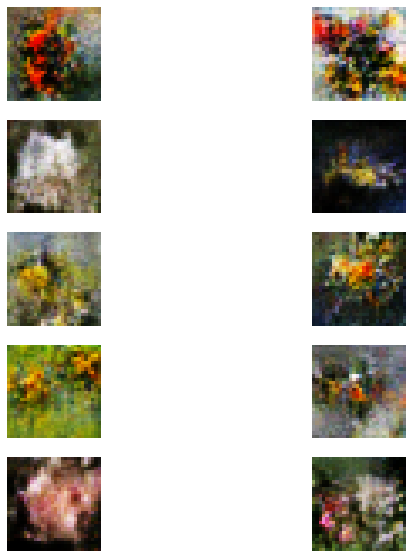

Time for epoch 625 is 8.178065538406372 sec


In [ ]:
train(train_dataset, EPOCHS)